In [1]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt

Recall our logistic cost function:
$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)})\right]
$$

When using high-order polynomials in our cost function, this can tend to lead to over-fitting, where $\theta_i$'s get large to create tightly turning decision boundaries.  We can avoid this through *regularization*, i.e., by adding a penalty term for large $\theta_i$'s.

$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)})\right] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2
$$

or vectorized

$$
J(\theta) = \frac{1}{m}\left(y^T\log(g(X\theta)) + (1-y)^T\log(1 - g(X\theta)\right) + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

In [2]:
def cost(theta, X, y, reg):
    m = y.size
    h = expit(X.dot(theta))

    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)) + reg/(2*m) * np.sum(np.square(theta)))
    J = J[0]

    if np.isnan(J):
        return np.inf
    return J

def cost_gradient(theta, X, y, reg):
    m = y.size
    theta = theta.reshape(-1, 1)
    h = expit(X.dot(theta))

    gradient = 1/m * X.T.dot(h - y) + reg/m * np.concatenate(([[0]], theta[1:])).reshape(-1, 1)
    return gradient.flatten()

For this demo let's use a fun data set that we can access through `scikit-learn`, which is the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), a famous well-curated database of handwritten digits.

In [3]:
from sklearn import datasets
digits = datasets.load_digits()

In [4]:
digits.data.shape

(1797, 64)

We should look at the documentation, but it looks like we have 1797 examples of 64-dimensional observations.  64 is suggestively a square number, so let's look at its values in a square grid.

6


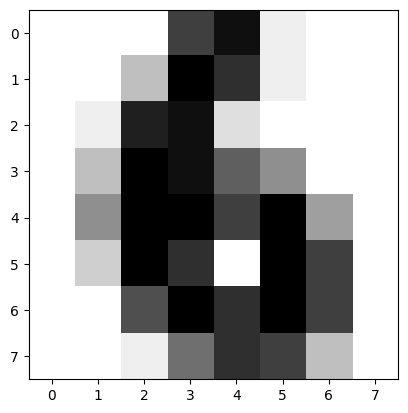

In [5]:
i = np.random.choice(len(digits.data))
plt.imshow(digits.data[i].reshape((8, 8)), cmap='gray_r')
print(digits.target[i])

## One-vs-All

Let's build a classifier capable of identifying each of the 10 digits.  To do this we'll use the one-vs-all technique, where we will train 10 separate classifies, each tasked with identifying one particular digit from the rest, then maximize over the returned probabilities to predict a particular digit provided an image.

In [6]:
training = np.random.choice([True, False], size=len(digits.data), p=[0.9, 0.1])
validating = ~training

In [7]:
m = np.count_nonzero(training)
mtest = np.count_nonzero(validating)
X = np.column_stack([np.ones((m, 1)), digits.data[training]])
Xtest = np.column_stack([np.ones((mtest, 1)), digits.data[validating]])

y = digits.target[training].reshape(-1, 1)
ytest = digits.target[validating].reshape(-1, 1)

[4 2 7 3 8]


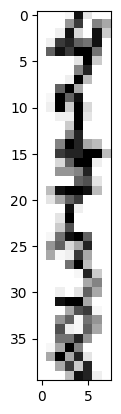

In [8]:
n = 5
sample = np.random.choice(X.shape[0], n)

plt.imshow(X[sample, 1:].reshape(-1, 8), cmap='Greys')
print(y[sample].flatten())

In [9]:
def one_v_all(X, y, n_classes, reg=0.1):
    n_features = X.shape[1]

    theta0 = np.zeros(n_features)  # I'd like this to be shape (n_features, 1), but scipy complains now
    thetas = np.zeros((n_classes, n_features))

    for cls in np.arange(n_classes):
        res = minimize(cost, theta0, args=(X, y==cls, reg), jac=cost_gradient, options={'maxiter':50})
        thetas[cls] = res.x
    return thetas

In [10]:
with np.errstate(divide='ignore'):
    theta = one_v_all(X, y, 10)

In [11]:
theta.shape

(10, 65)

In [12]:
def predict_one_v_all(thetas, X):
    Ps = expit(X.dot(theta.T))
    
    return np.argmax(Ps, axis=1)

In [13]:
pred = predict_one_v_all(theta, X)
predtest = predict_one_v_all(theta, Xtest)

training_acc = np.mean(pred == y.ravel())*100
validation_acc = np.mean(predtest == ytest.ravel())*100
print(training_acc, validation_acc)

99.75062344139651 92.74611398963731


prediction: [6]
truth: [6]


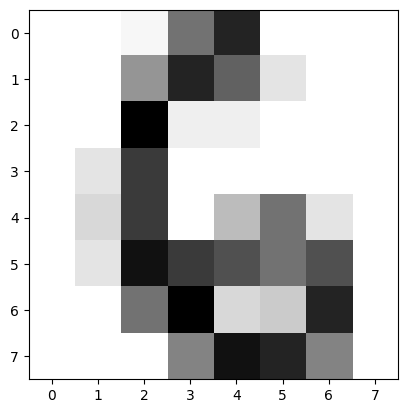

In [14]:
i = np.random.choice(Xtest.shape[0])

plt.imshow(Xtest[i, 1:].reshape(-1, 8), cmap='Greys')
print("prediction: {}".format(predict_one_v_all(theta, Xtest[i:i+1])))
print("truth: {}".format(ytest[i]))

In [15]:
n_classes = len(np.unique(y))
print(n_classes)
C = np.zeros((n_classes, n_classes))

10


In [16]:
for prediction, truth in zip(predtest, ytest):
    C[prediction, truth] += 1

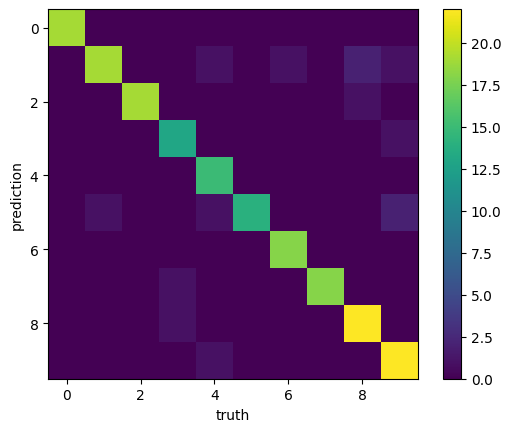

In [17]:
plt.imshow(C)
plt.colorbar()
plt.ylabel('prediction')
plt.xlabel('truth');

# The 3est 3

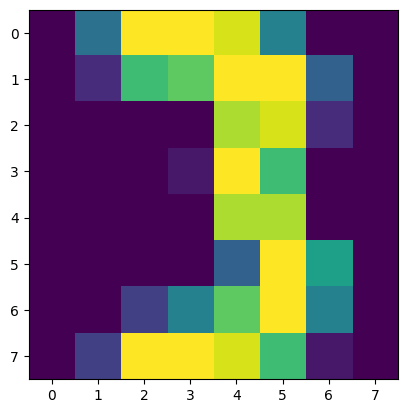

In [18]:
num_of_interest = 3

while True:
    i = np.random.randint(X.shape[0])
    if y[i] == num_of_interest:
        break
x0 = X[i]
plt.imshow(x0[1:].reshape((8, 8)))

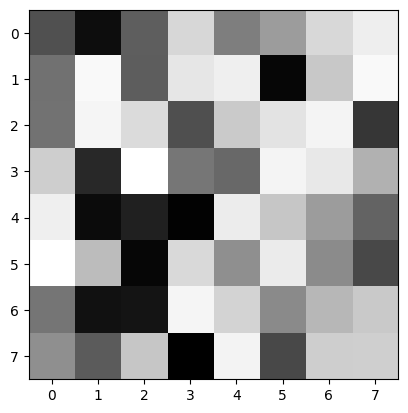

In [19]:
x0 = np.random.uniform(0, 16, size=X.shape[1])
x0[0] = 1
plt.imshow(x0[1:].reshape((8, 8)), cmap='Greys');

In [20]:
def prob(x, thetas=theta, num_of_interest=3):
    return expit(x.dot(thetas[num_of_interest]))

def neg_prob(x, thetas=theta, num_of_interest=3):
    return -prob(x, thetas=thetas, num_of_interest=num_of_interest)

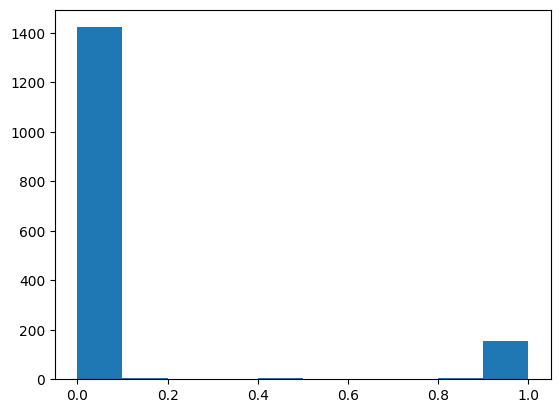

In [21]:
plt.hist([prob(x) for x in X]);

In [22]:
print(neg_prob(x0))

-4.380993413924918e-17


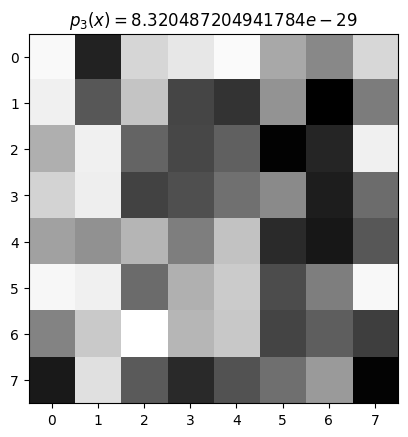

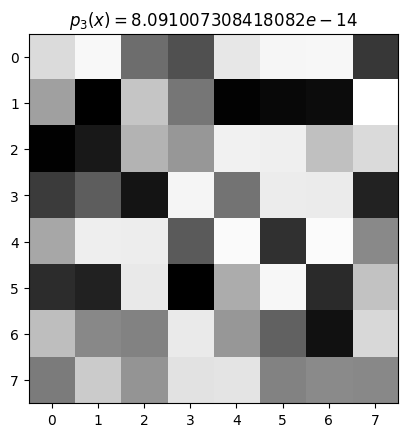

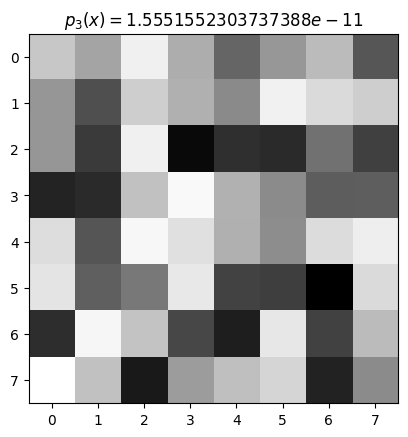

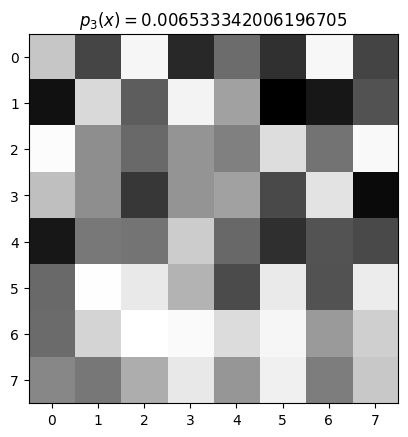

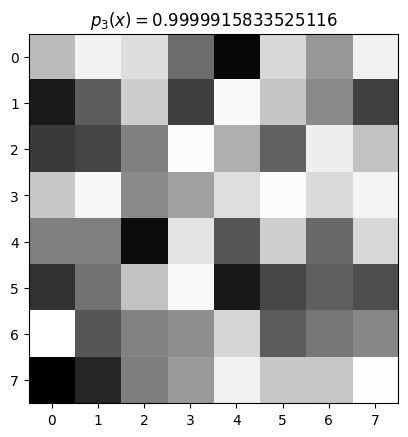

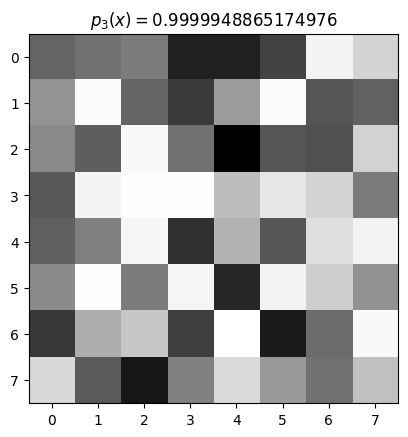

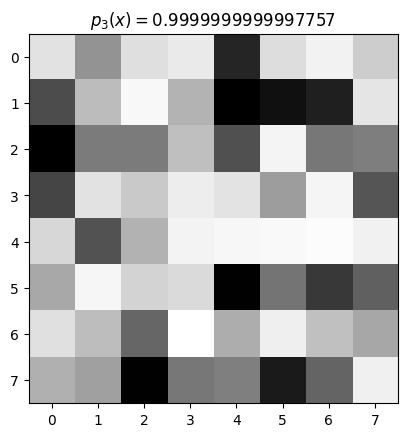

In [23]:
i = 0

x = np.random.uniform(0, 16, size=X.shape[1])
x[1] = 1
p = prob(x)
plt.imshow(x[1:].reshape(-1, 8), cmap='Greys')
plt.title(r'$p_{}(x) = {}$'.format(num_of_interest, p))
plt.show()

while i < 10000:
    xp = np.random.uniform(0, 16, size=X.shape[1])
    xp[0] = 1
    
    if prob(xp) > p:
        x = xp
        p = prob(xp)
        plt.imshow(x[1:].reshape(-1, 8), cmap='Greys')
        plt.title(r'$p_{}(x) = {}$'.format(num_of_interest, p))
        plt.show()
        if p == 1.:
            break
    i += 1

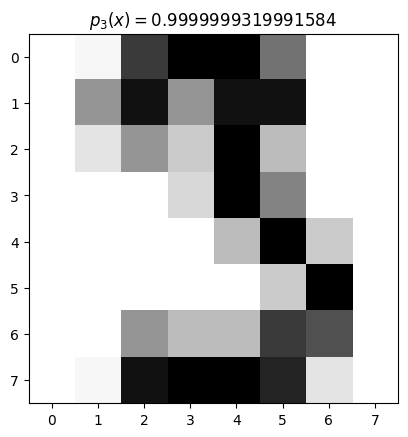

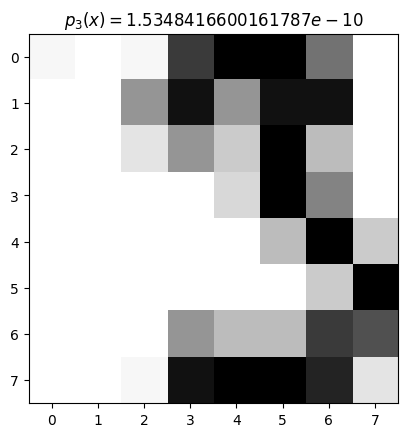

In [24]:
while True:
    i = np.random.randint(X.shape[0])
    if y[i] == num_of_interest:
        break
x0 = X[i]

plt.imshow(x0[1:].reshape(-1, 8), cmap='Greys')
plt.title(r'$p_{}(x) = {}$'.format(num_of_interest, prob(x0)))
plt.show()

x = np.roll(x0, 1, axis=0)
plt.imshow(x[1:].reshape(-1, 8), cmap='Greys')
plt.title(r'$p_{}(x) = {}$'.format(num_of_interest, prob(x)));